In [ ]:
# [CompuCell3D](http://compucell3d.org) in a Jupyter Notebook

> CompuCell3D is an open-source simulation environment for multi-cell, single-cell-based modeling of tissues, organs and organisms.

>It uses Cellular Potts Model to model cell behavior.

>This project is funded by the NIH and EPA.

>Compucell3D is led by Maciej Swat (IU), James Glazier(IU) and Roshan D'Souza (U.Wisc. Milwaukee) 

## Structure of the Simulations directory tree

* DATA_ROOT
    - ...
    - Sim2_cc3d_dd_MM_yyyy_hh_mm_ss
        * LatticeData
            - vtk_files ... **Here are the data**
        * Simulation
            - xml & python files ...
    
    
    - ...
    


### Parsing xml and python files

This is used for parameters management

In [1]:
import os
from xml.etree import ElementTree

import matplotlib.pylab as plt
%matplotlib inline
import vtk
from vtk.util.numpy_support import vtk_to_numpy


In [187]:
# TODO: do a widget for that
DATA_ROOT = '/home/guillaume/Projets/NeuroBlasts/CancerStemCells_GGH/simulation_data/'

folder_num = 5

print('***************\n')
print('Using: #{} - {}\n'.format(folder_num, data_dir))

data_dirs = os.listdir(DATA_ROOT)
data_dir = os.path.join(DATA_ROOT,
                        data_dirs[folder_num])

def parse_cc3d(data_dir, simname):
    
    sim_dict = {}
    sim_str = []

    xml_file = os.path.join(data_dir+'/Simulation/{}.xml'.format(simname))
    py_file = os.path.join(data_dir+'/Simulation/{}Steppables.py'.format(simname))

    xml_tree = ElementTree.ElementTree(file=xml_file)
    xml_root = xml_tree.getroot()

    for child in xml_root:

        if child.tag == 'Potts':
            steps = int(child.find('Steps').text)
            dim = {k: int(v) for k, v 
                   in child.find('Dimensions').items()}

        elif child.get('Name') == 'Contact':
            energies = child.findall('Energy')
            energies = {(energy.attrib['Type1'],
                         energy.attrib['Type2']):
                        float(energy.text) for energy in energies}

    sim_str.append('\n***************')
    sim_str.append('**  Energies **\n')
    sim_dict['energies'] = energies
    for e in energies.items():
        sim_str.append(e)


    pysettings = []
    with open(py_file) as pf:
        start_parse = False
        for line in pf.readlines():
            if line.startswith('# <parameter settings>'):
                start_parse = True
            elif start_parse:
                pysettings.append(line)
            elif line.startswith('# </parameter settings>'):
                break

    for l in pysettings:
        exec(l)           


    pyparams = {'growth_rate':growth_rate,
                'P_sr': P_sr,
                'P_ar': P_ar,
                'P_sd': P_sd}
    sim_dict['energies'] = energies
    
    sim_str.append('\n***************')
    sim_str.append('**  python set variables **\n')
    for p in pyparams.items():
        sim_str.append(p)

    vtk_dir = os.path.join(data_dir,'LatticeData')

    vtk_files = [os.path.join(vtk_dir, f) 
                 for f in os.listdir(vtk_dir)
                 if f.endswith('.vtk')]
    vtk_files.sort()

    sim_str.append('\n***************')
    sim_str.append('**  VTK files **\n')
    sim_str.append('starts: {}\n stops: {}'.format(vtk_files[0], vtk_files[-1]))
    return sim_dict

sim_dict = parse_cc3d(data_dir, simname)
    

***************

Using: #5 - /home/guillaume/Projets/NeuroBlasts/CancerStemCells_GGH/simulation_data/Sim2_cc3d_05_07_2015_11_51_27



SyntaxError: unqualified exec is not allowed in function 'parse_cc3d' because it contains a nested function with free variables (<ipython-input-187-9bb2d17c6fd6>, line 56)

In [3]:
reader = vtk.vtkStructuredPointsReader()

vtk_fnum = -1
#reader = vtkUnstructuredGridReader()
reader.SetFileName(vtk_files[vtk_fnum])
reader.Update()
field_data = reader.GetOutput()
cell_type = vtk_to_numpy(field_data.GetPointData().GetArray('CellType')) ##CellId, ClusterId
cell_type = cell_type.reshape((dim['x'], dim['y']))
cell_id = vtk_to_numpy(field_data.GetPointData().GetArray('CellId')).reshape((dim['x'], dim['y']))
cluster_id = vtk_to_numpy(field_data.GetPointData().GetArray('ClusterId')).reshape((dim['x'], dim['y']))


reader.CloseVTKFile()

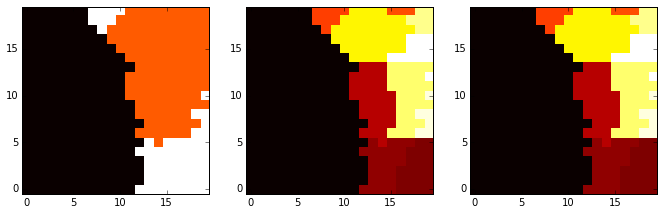

In [14]:
dpi = 90. # pixel per inch 
pix_width = 1024
pix_height = 720

f_size_i = (pix_width/dpi, pix_height/dpi)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(f_size_i)
for ax, data in zip(axes, [cell_type, cell_id, cluster_id]):
    ax.imshow(data[:20, :20], cmap='hot', origin='lower', interpolation='nearest')

In [8]:
import numpy as np

In [12]:
np.bincount(cell_id.ravel())

array([208603,     24,     36, ...,     21,     21,     21])

In [22]:
from skimage.filters import rank
from skimage.morphology import disk

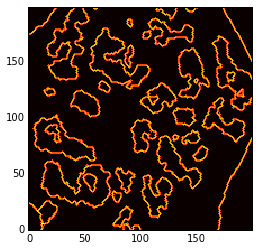

In [41]:
fig, ax = plt.subplots()

pix_entropy = rank.entropy(cell_type, disk(1))

ax.imshow(pix_entropy[:200, :200], cmap='hot', origin='lower', interpolation='nearest')

In [40]:
np.unique(pix_entropy)

array([ 0.        ,  0.72192809,  0.81127812,  0.97095059,  1.        ,
        1.37095059,  1.52192809])

In [46]:
cell_id.astype(np.uint16)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [53]:
from skimage import filters

In [67]:

from skimage.future import graph

In [65]:
boundaries = filters.edges.sobel(cell_id.astype(np.float))
ax.imshow(boundaries[:20, :20], cmap='hot', origin='lower', interpolation='nearest')

fig

In [69]:
rag = graph.rag_mean_color(cell_type, cell_id)

In [72]:
rag.edges()

[(0, 2),
 (0, 3),
 (0, 5),
 (0, 518),
 (0, 523),
 (0, 1038),
 (0, 16),
 (0, 24),
 (0, 538),
 (0, 1062),
 (0, 556),
 (0, 560),
 (0, 56),
 (0, 58),
 (0, 71),
 (0, 90),
 (0, 608),
 (0, 1128),
 (0, 106),
 (0, 108),
 (0, 110),
 (0, 1650),
 (0, 122),
 (0, 639),
 (0, 134),
 (0, 650),
 (0, 142),
 (0, 1680),
 (0, 662),
 (0, 151),
 (0, 156),
 (0, 157),
 (0, 671),
 (0, 1190),
 (0, 680),
 (0, 170),
 (0, 180),
 (0, 181),
 (0, 694),
 (0, 194),
 (0, 196),
 (0, 1232),
 (0, 211),
 (0, 1239),
 (0, 228),
 (0, 233),
 (0, 747),
 (0, 753),
 (0, 248),
 (0, 1276),
 (0, 384),
 (0, 265),
 (0, 1293),
 (0, 271),
 (0, 26),
 (0, 275),
 (0, 280),
 (0, 804),
 (0, 298),
 (0, 315),
 (0, 316),
 (0, 317),
 (0, 319),
 (0, 321),
 (0, 352),
 (0, 656),
 (0, 362),
 (0, 378),
 (0, 896),
 (0, 394),
 (0, 1422),
 (0, 406),
 (0, 1432),
 (0, 419),
 (0, 420),
 (0, 424),
 (0, 668),
 (0, 669),
 (0, 447),
 (0, 455),
 (0, 461),
 (0, 471),
 (0, 472),
 (0, 483),
 (0, 485),
 (0, 492),
 (0, 1006),
 (0, 168),
 (0, 511),
 (1, 98),
 (1, 908),


In [130]:
import pandas as pd
fliped = [(t, s) for s, t in rag.edges()]
bi_direct = rag.edges() + fliped
e_idx = pd.MultiIndex.from_tuples(bi_direct, 
                                  names=['srce', 'trgt'])

v_idx = pd.Index(rag.nodes(), name='vertex')


types = pd.Series([cell_type[cell_id==i][0] for i in v_idx],
                  index=v_idx, name='type')
trgt_types = pd.Series(types.loc[e_idx.get_level_values('trgt')].values, index=e_idx)
srce_type = pd.Series(types.loc[e_idx.get_level_values('srce')].values, index=e_idx)

In [129]:
ex = trgt_types.loc[1705]

In [133]:
diff = trgt_types == srce_type

In [136]:
diff.loc[1705].size, diff.loc[1705].sum()

(6, 5)

In [137]:
sp.special.binom(diff.loc[1705].size, diff.loc[1705].sum())

6.0

In [153]:
pis = diff.groupby(level='srce').apply(lambda df: sp.special.binom(df.size, df.sum())/2**df.size)

In [156]:
pis


srce
0       1.615587e-27
1       6.250000e-02
2       2.500000e-01
3       1.562500e-01
4       3.125000e-02
5       1.562500e-01
6       1.562500e-02
7       1.562500e-02
8       1.562500e-02
9       3.906250e-03
10      7.812500e-03
11      7.812500e-03
12      1.562500e-02
13      6.250000e-02
14      3.125000e-02
15      1.562500e-02
16      2.734375e-01
17      1.953125e-03
18      7.812500e-03
19      7.812500e-03
20      7.812500e-03
21      1.640625e-01
22      1.562500e-02
23      1.562500e-02
24      1.562500e-01
25      7.812500e-03
26      2.343750e-01
27      3.125000e-02
28      7.812500e-03
29      1.562500e-02
            ...     
1743    2.734375e-01
1744    2.734375e-01
1745    3.125000e-01
1746    2.734375e-01
1747    3.125000e-01
1748    1.562500e-02
1749    2.734375e-01
1750    3.125000e-01
1751    2.343750e-01
1752    1.640625e-01
1753    2.343750e-01
1754    2.343750e-01
1755    9.375000e-02
1756    9.375000e-02
1757    2.460938e-01
1758    3.125000e-01
1759    

In [167]:
entropy = - pis * np.log2(pis)
entropy_field = cell_type.copy().astype(np.float)
for lbl in v_idx:
    entropy_field[cell_id == lbl] = entropy.loc[lbl]

entropy_field = entropy_field / entropy_field.max()

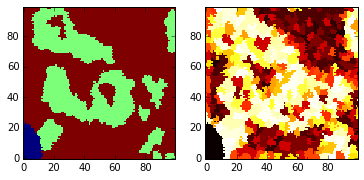

In [171]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cell_type[:100, :100], origin='lower', interpolation='nearest')
axes[1].imshow(entropy_field[:100, :100], cmap='hot', origin='lower', interpolation='nearest')

In [174]:
entropy.loc[1:].mean()

0.28840323625760944

In [185]:
axes[1].imshow(entropy_field[:100, :100] * (cell_type[:100, :100] == 1),
               cmap='hot', origin='lower', interpolation='nearest')

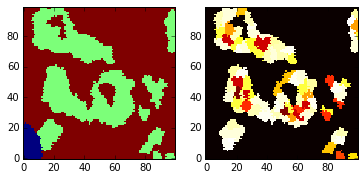

In [186]:
fig